In [8]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from mingpt.utils import set_seed
set_seed(3407)

## Add

In [9]:
import random

def random_add_instance(length):
    a = [random.randint(0,9) for i in range(length)]
    b = [random.randint(0,9) for i in range(length)]
    val_a = int(''.join(str(d) for d in a))
    val_b = int(''.join(str(d) for d in b))
    val_c = val_a + val_b
    str_c = str(val_c)
    str_c = (length + 1 - len(str_c)) * '0' + str_c
    return a + b + [int(d) for d in str_c]

for i in range(10):
    print (random_add_instance(3))



[0, 6, 2, 5, 3, 6, 0, 5, 9, 8]
[4, 9, 5, 3, 7, 8, 0, 8, 7, 3]
[6, 4, 4, 3, 1, 4, 0, 9, 5, 8]
[3, 5, 9, 1, 1, 9, 0, 4, 7, 8]
[3, 5, 0, 1, 4, 8, 0, 4, 9, 8]
[0, 0, 2, 9, 3, 7, 0, 9, 3, 9]
[8, 4, 8, 2, 3, 7, 1, 0, 8, 5]
[9, 9, 9, 7, 0, 6, 1, 7, 0, 5]
[7, 4, 5, 1, 3, 6, 0, 8, 8, 1]
[1, 0, 1, 0, 4, 2, 0, 1, 4, 3]


In [10]:
class AddDataset(Dataset):
    """ 
    Dataset for the Add problem. E.g. for problem length 3:
    12 + 333 = 345
    Input: 0 1 2 3 3 3 -> Output: 0 3 4 5
    Which will feed into the transformer concatenated as:
    input:  0 1 2 3 3 3 0 3 4
    output: I I I I I 0 3 4 5
    where I is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return 10
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return 3 * self.length + 1 - 1

    def __getitem__(self, idx):
        while True:
            rai = random_add_instance(self.length)
            h = hash(str(rai[:2*self.length]))
            
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        x = torch.tensor(rai[:-1], dtype=torch.long)
        y = torch.tensor(rai[1:], dtype=torch.long)
        
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:2*self.length-1] = -1
        return x, y

In [11]:
# print an example instance of the dataset
train_dataset = AddDataset('train')
test_dataset = AddDataset('test')
x, y = train_dataset[0]

print (x)
for a, b in zip(x,y):
    print(int(a),int(b))

tensor([2, 9, 3, 4, 8, 0, 0, 7, 7])
2 -1
9 -1
3 -1
4 -1
8 -1
0 0
0 7
7 7
7 3


In [107]:
# create a GPT instance
from mingpt.model import GPT

HEADS = 4
LAYERS = 4
EMBEDDING_DIM = 128

model_config = GPT.get_default_config()
model_config.model_type = 'gpt-micro'
model_config.n_heads = HEADS
model_config.n_layers = LAYERS
model_config.n_embd = EMBEDDING_DIM
# model_config.model_type = 'gpt-nano'

model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)

number of parameters: 0.80M


In [111]:
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if os.path.exists(f'../weights/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth'):
    model.load_state_dict(torch.load(f'../weights/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth', map_location=device))
    print(model_config.n_heads, model_config.n_layers, model_config.n_embd)


4 4 128


/tmp/ipykernel_1780/1523802148.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../weights/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth'

In [113]:
# create a Trainer object
from mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 1e-5 # the model we're using is so small that we can go a bit faster
train_config.max_iters = 5000
train_config.num_workers = 0
trainer = Trainer(train_config, model, train_dataset)

running on device cuda


In [90]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

iter_dt 0.00ms; iter 0: train loss 0.06537
iter_dt 12.99ms; iter 100: train loss 0.03939
iter_dt 11.97ms; iter 200: train loss 0.05999
iter_dt 12.35ms; iter 300: train loss 0.05009
iter_dt 11.81ms; iter 400: train loss 0.05066
iter_dt 11.51ms; iter 500: train loss 0.05000
iter_dt 11.65ms; iter 600: train loss 0.04873
iter_dt 11.86ms; iter 700: train loss 0.04221
iter_dt 11.89ms; iter 800: train loss 0.06120
iter_dt 12.20ms; iter 900: train loss 0.03325
iter_dt 11.60ms; iter 1000: train loss 0.05038
iter_dt 12.02ms; iter 1100: train loss 0.04104
iter_dt 11.65ms; iter 1200: train loss 0.03307
iter_dt 11.87ms; iter 1300: train loss 0.02436
iter_dt 12.09ms; iter 1400: train loss 0.08128
iter_dt 11.68ms; iter 1500: train loss 0.06672
iter_dt 11.62ms; iter 1600: train loss 0.05607
iter_dt 13.21ms; iter 1700: train loss 0.05252
iter_dt 12.23ms; iter 1800: train loss 0.04448
iter_dt 12.48ms; iter 1900: train loss 0.05457
iter_dt 11.72ms; iter 2000: train loss 0.03107
iter_dt 12.20ms; iter 2100

KeyboardInterrupt: 

In [114]:
# now let's perform some evaluation
model.eval()
None

In [115]:
c_vals = []
w_vals = []

def eval_add_split(trainer, split, max_batches):
    dataset = {'train':train_dataset, 'test':test_dataset}[split]
    n = train_dataset.length # naugy direct access shrug
    results = []
    mistakes_printed_already = 0
    loader = DataLoader(dataset, batch_size=100, num_workers=0, drop_last=False)
    #loader = DataLoader(dataset, batch_size=1, num_workers=0, drop_last=False)
    for b, (x, y) in enumerate(loader):
        x = x.to(trainer.device)
        y = y.to(trainer.device)

        inp = x[:, :2*n]
        sol = y[:, -n-1:]
        
        cat = model.generate(inp, n+1, do_sample=False) # using greedy argmax, not sampling
        sol_candidate = cat[:, -n-1:]         
        correct = (sol == sol_candidate).all(1).cpu() 
        incorrect = ~correct
        # print("Incorrect:", incorrect)
        c_vals.extend(sol[incorrect].tolist())
        w_vals.extend(sol_candidate[incorrect].tolist())
        # print(sol[incorrect].tolist())
        # mae = (sol[incorrect] - sol_candidate[incorrect])
        # print(mae.tolist())
        # errors.extend(mae.tolist())
        for i in range(x.size(0)):
            results.append(int(correct[i]))
    
    rt = torch.tensor(results, dtype=torch.float)
    print("%s final score: %d/%d = %.2f%% correct" % (split, rt.sum(), len(results), 100*rt.mean()))
    return rt.sum()

# run a lot of examples from both train and test through the model and verify the output correctness
with torch.no_grad():
    train_score = eval_add_split(trainer, 'train', max_batches=50)
    test_score  = eval_add_split(trainer, 'test',  max_batches=50)

train final score: 9963/10000 = 99.63% correct
test final score: 9954/10000 = 99.54% correct


In [93]:
errors = []

for c, w in zip(c_vals, w_vals):
    a = int(''.join(str(d) for d in c))
    b = int(''.join(str(d) for d in w))
    # print(a, b)
    # print(abs(a-b))
    errors.append(abs(a-b))

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


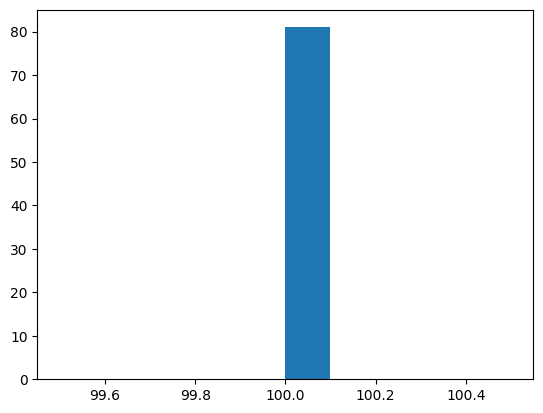

In [101]:
import matplotlib.pyplot as plt

print (errors)

plt.hist(errors)
# plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])
plt.show()

In [ ]:
torch.save(model.state_dict(), f'../weights/st_add_{HEADS}_{LAYERS}_{EMBEDDING_DIM}.pth')